# 8章　MNISTを使った数字認識

In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [2]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

## 8.3 ReLU関数

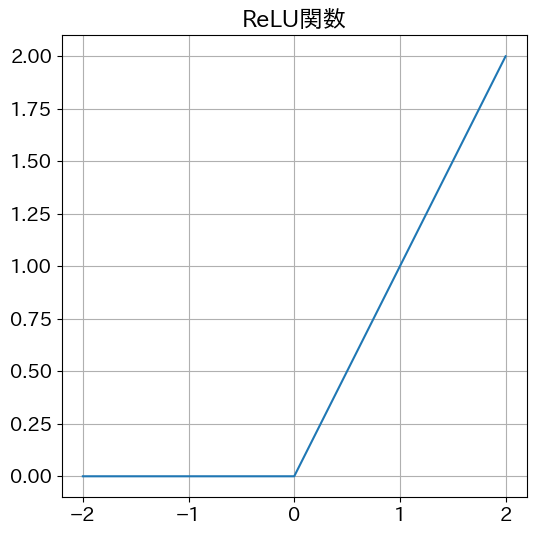

In [4]:
# ReLU関数のグラフ

relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()

## 8.4 GPU利用

### GPUチェック

In [5]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# テスト用tensor変数x , y 
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

# xとyの間の演算
z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [7]:
# 変数xをGPUに送る
x = x.to(device)

# 変数xとyの属性data, deviceの確認
print('x: ', x.device)
print('y: ', y.device)

x:  cpu
y:  cpu


In [8]:
# この状態でxとyの演算をすると。。。

z = x * y

In [9]:
# yもGPUに送る
y = y.to(device)

# 今度は計算可能になる
z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


## 8.8 データ準備1 (データセットによる読み込み)

In [10]:
# ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root = data_root,  
    # 訓練データか検証データか
    train = True,  
    # 元データがない場合にダウンロードするか
    download = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2992219.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 137073.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1200296.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2093234.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
# ダウンロードしたファイルの確認

!ls -lR ./data/MNIST

./data/MNIST:
total 0
drwxr-xr-x 1 jovyan users 4096 Oct  1 15:48 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 jovyan users  7840016 Oct  1 15:48 t10k-images-idx3-ubyte
-rw-r--r-- 1 jovyan users  1648877 Oct  1 15:48 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 jovyan users    10008 Oct  1 15:48 t10k-labels-idx1-ubyte
-rw-r--r-- 1 jovyan users     4542 Oct  1 15:48 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 jovyan users 47040016 Oct  1 15:48 train-images-idx3-ubyte
-rw-r--r-- 1 jovyan users  9912422 Oct  1 15:48 train-images-idx3-ubyte.gz
-rw-r--r-- 1 jovyan users    60008 Oct  1 15:48 train-labels-idx1-ubyte
-rw-r--r-- 1 jovyan users    28881 Oct  1 15:48 train-labels-idx1-ubyte.gz


In [13]:
# データ件数の確認
print('データ件数: ', len(train_set0))

# 最初の要素の取得
image, label = train_set0[0]

# データ型の確認
print('入力データの型: ', type(image))
print('正解データの型: ', type(label))

データ件数:  60000
入力データの型:  <class 'PIL.Image.Image'>
正解データの型:  <class 'int'>


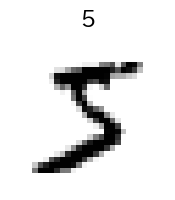

In [14]:
# 入力データの画像表示

plt.figure(figsize=(2,3))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

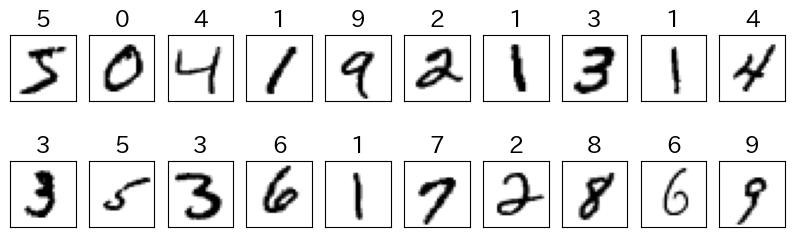

In [15]:
# 正解データ付きで、最初の20個をイメージ表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # image と labelの取得
    image, label = train_set0[i]
    
    # イメージ表示
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 8.9 データ準備2 (Transformsによるデータ前処理)

### Step1 ToTensorの利用

In [ ]:
# ライブラリインポート
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root,  train=True,  download=True,
    transform = transform1)

In [ ]:
# 変換結果の確認

image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

### Step2 Normalizeの利用

In [ ]:
transform2 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5,  0.5),
])

train_set2 = datasets.MNIST(
    root = data_root,  train = True,  download = True,
    transform = transform2)

In [ ]:
# 変換結果の確認

image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

### Step3 Lambdaを利用して1階テンソル化

In [ ]:
transform3 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # Tensorの1階テンソル化
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root,  train = True,  
    download=True, transform = transform3)

In [ ]:
# 変換結果の確認

image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

### 最終的な実装

In [ ]:
# データ変換用関数 Transforms
# (1) Imageをテンソル化
# (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
# (3) データのshapeを[1, 28, 28]から[784]に変換

transform = transforms.Compose([
    # (1) データのテンソル化
    transforms.ToTensor(),
    
    # (2) データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # (3) 1階テンソルに変換
    transforms.Lambda(lambda x: x.view(-1)),
])

In [ ]:
# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False, 
    download = True, transform = transform)

## 8.10 データ準備3 データローダーによるミニバッチ用データ生成)

In [ ]:
# ライブラリインポート
from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 500

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size, 
    shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,  batch_size = batch_size, 
    shuffle = False) 

In [ ]:
# 何組のデータが取得できるか
print(len(train_loader))

# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

In [ ]:
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # numpyに変換
    image = images[i].numpy()
    label = labels[i]
    
    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

全体で60000件ある訓練データが120個のグループに分割されて取得できていることがわかります。  
今回はテスト用でシャッフルなしでデータを取得しましたが、訓練データは取得のたびにシャッフルがかかります。  
つまり、ミニバッチ用のデータセットが自動的に取得できていることになります。

## 8.11 モデル定義

In [ ]:
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = 10

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

In [ ]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [ ]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden)

# モデルをGPU側に送る
net = net.to(device)

### 最適化アルゴリズムと損失関数

In [ ]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

### モデル確認

In [ ]:
# モデル内のパラメータの確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

In [ ]:
# モデルの概要表示

print(net)

In [ ]:
# モデルのサマリー表示

summary(net, (784,))

## 8.12 勾配降下法

### 予測計算

In [ ]:
# 訓練データセット　最初の1項目を取得
# データローダーから最初の1セットを取得する
for images, labels in train_loader:
    break 

In [ ]:
# データローダーから取得したデータをGPUに送る
inputs = images.to(device)
labels = labels.to(device)

In [ ]:
# 予測計算
outputs = net(inputs)

# 結果確認
print(outputs)

### 損失関数

#### 損失計算と計算グラフの可視化

In [ ]:
#  損失計算
loss = criterion(outputs, labels)

# 損失値の取得
print(loss.item())

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 勾配計算

In [ ]:
# 勾配計算の実行
loss.backward()

In [ ]:
# 勾配計算の結果
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

### パラメータ修正

In [ ]:
# 勾配降下法の適用
optimizer.step()

In [ ]:
# パラメータ値の表示
print(net.l1.weight)
print(net.l1.bias)

### 繰り返し計算

In [ ]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

In [ ]:
# tqdmライブラリのインポート
from tqdm.notebook import tqdm

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 1エポックあたりの正解数(精度計算用)
    n_train_acc, n_val_acc = 0, 0
    # 1エポックあたりの累積損失(平均化前)
    train_loss, val_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        # 1バッチあたりのデータ件数
        train_batch_size = len(labels)
        # 1エポックあたりのデータ累積件数
        n_train += train_batch_size

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        train_loss += loss.item() * train_batch_size 
        n_train_acc += (predicted == labels).sum().item() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        # 1バッチあたりのデータ件数
        test_batch_size = len(labels_test)
        # 1エポックあたりのデータ累積件数
        n_test += test_batch_size

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)
            
        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        #  平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        val_loss +=  loss_test.item() * test_batch_size
        n_val_acc +=  (predicted_test == labels_test).sum().item()

    # 精度計算
    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_test
    # 損失計算
    ave_train_loss = train_loss / n_train
    ave_val_loss = val_loss / n_test
    # 結果表示
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} val_loss: {ave_val_loss:.5f}, val_acc: {val_acc:.5f}')
    # 記録
    item = np.array([epoch+1 , ave_train_loss, train_acc, ave_val_loss, val_acc])
    history = np.vstack((history, item))

## 8.13 結果確認

In [ ]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

In [ ]:
# 学習曲線の表示 (損失)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

In [ ]:
# 学習曲線の表示 (精度)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### イメージ表示で確認

In [ ]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

In [ ]:
# 最初の50件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
    
  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2
    
  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## 8.14 隠れ層の2層化

In [ ]:
# モデルの定義
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [ ]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルインスタンス生成
net = Net2(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# モデルの概要表示

print(net)

In [ ]:
# モデルのサマリー表示

summary(net, (784,))

In [ ]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)

In [ ]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
make_dot(loss, params=dict(net.named_parameters()))

### 勾配計算

In [ ]:
# 勾配計算
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu').l1.weight.grad.numpy()
print(w)

# 各要素の絶対値の平均
print(np.abs(w).mean())

### 繰り返し計算

In [ ]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# モデルインスタンス生成
net = Net2(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 200

# 評価結果記録用
history2 = np.zeros((0,5))

In [ ]:
# tqdmライブラリのインポート
from tqdm.notebook import tqdm

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 1エポックあたりの正解数(精度計算用)
    n_train_acc, n_val_acc = 0, 0
    # 1エポックあたりの累積損失(平均化前)
    train_loss, val_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        # 1バッチあたりのデータ件数
        train_batch_size = len(labels)
        # 1エポックあたりのデータ累積件数
        n_train += train_batch_size

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        train_loss += loss.item() * train_batch_size 
        n_train_acc += (predicted == labels).sum().item() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        # 1バッチあたりのデータ件数
        test_batch_size = len(labels_test)
        # 1エポックあたりのデータ累積件数
        n_test += test_batch_size

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)
            
        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        #  平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        val_loss +=  loss_test.item() * test_batch_size
        n_val_acc +=  (predicted_test == labels_test).sum().item()

    # 精度計算
    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_test
    # 損失計算
    ave_train_loss = train_loss / n_train
    ave_val_loss = val_loss / n_test
    # 結果表示
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} val_loss: {ave_val_loss:.5f}, val_acc: {val_acc:.5f}')
    # 記録
    item = np.array([epoch+1 , ave_train_loss, train_acc, ave_val_loss, val_acc])
    history2 = np.vstack((history2, item))

In [ ]:
#損失と精度の確認

print(f'初期状態: 損失: {history2[0,3]:.5f} 精度: {history2[0,4]:.5f}' )
print(f'最終状態: 損失: {history2[-1,3]:.5f} 精度: {history2[-1,4]:.5f}' )

In [ ]:
# 学習曲線の表示 (損失)

plt.plot(history2[:,0], history2[:,1], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history2[:,0], history2[:,2], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

## コラム　勾配消失とReLU関数

In [ ]:
# モデルの定義　シグモイド関数バージョン
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net3(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # シグモイド関数の定義
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        x3 = self.l2(x2)
        x4 = self.sigmoid(x3)
        x5 = self.l3(x4)
        return x5

In [ ]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルインスタンス生成
net = Net3(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)

In [ ]:
# 予測計算
outputs = net(inputs)

# 損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
# 勾配計算
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu').l1.weight.grad.numpy()
print(w)

# 各要素の絶対値の平均
print(np.abs(w).mean())

## コラム　lambda式による関数定義

In [ ]:
# 通常の関数定義

def f(x):
    return (2 * x**2 + 2)

In [ ]:
x = np.arange(-2, 2.1, 0.25)
y = f(x)
print(y)

In [ ]:
# lambda式による関数定義

g = lambda x: 2 * x**2 + 2

In [ ]:
y = g(x)
print(y)

## コラム バッチサイズと精度

### fit関数の定義

In [ ]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
    
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size 
            n_train_acc += (predicted == labels).sum().item() 

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)
 
            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

In [ ]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [ ]:
# ミニバッチのサイズ指定
batch_size_train = 500

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 乱数の固定化
torch_seed()

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history6 = np.zeros((0,5))

In [ ]:
history6 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history6)

### batch_size=200

In [ ]:
# ミニバッチのサイズ指定
batch_size_train = 200

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 乱数の固定化
torch_seed()

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history3 = np.zeros((0,5))

In [ ]:
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

### batch_size=100

In [ ]:
# ミニバッチのサイズ指定
batch_size_train = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 乱数の固定化
torch_seed()

# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history4 = np.zeros((0,5))

In [ ]:
history4 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history4)

### batch_size=50

In [ ]:
# ミニバッチのサイズ指定
batch_size_train = 50

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 乱数の固定化
torch_seed()

# 学習率
lr = 0.01

# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history5 = np.zeros((0,5))

In [ ]:
history5 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history5)

### 学習曲線の比較

In [ ]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,4], label='batch_size=500', c='k', linestyle='-.')
plt.plot(history3[:,0], history3[:,4], label='batch_size=200', c='b', linestyle='-.')
plt.plot(history4[:,0], history4[:,4], label='batch_size=100', c='k')
plt.plot(history5[:,0], history5[:,4], label='batch_size=50', c='b')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()